# Week 7 - Community Detection 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import networkx as nx

%matplotlib inline

## Exercise 1: Programming Modularity

In this exercise, we will implement modularity and spectral modularity.
If we assume two partitions described by indicator-vector $s \in \{-1, 1\}^n$ where $s_i$ is $-1$ if node $i$ is in one group and $1$ if it is in the other, 
then we can formulate modularity as

$$ 
Q(G, S) = \frac{1}{2 m} \sum_{i, j \in V}\left(A_{ij}-\frac{k_{i} k_{j}}{2 m}\right) \frac{1}{2}(s_i s_j + 1)\\
= \frac{1}{4m} \sum_{i, j \in V} \left( A_{ij} - \frac{k_i k_j}{2m} \right) s_i s_j \\
\propto s^T B s\qquad \qquad \qquad \qquad \\
= \sum_{i}(u_i^T s)^2 \beta_i \qquad \qquad
$$ 

where $S$ is the set of clusters in the graph, $A$ is the adjacency matrix, and $k_i$ is the expected number of edges of node $i$ and
$B_{ij} = A_{ij} - \frac{k_i k_j}{2m}$ and $u_i$ ($\beta_i$) are eigenvectors (eigenvalues) of $B$.

In [4]:
def M_eq(G, s):
    """
        args:
            G: an Networkx graph
            s: an indicatorvector of {-1, 1} indicating which cluster each node corresponds to.
    """
    Q = 0
    B = nx.modularity_matrix(G)
    B = np.array(B)
    d, U = np.linalg.eig(B)
    d, U = np.real(d), np.real(U)
    Q = ((s @ U) ** 2 * d).sum() / (4 * G.size())
    
    return Q

Below is some code to test the computations.

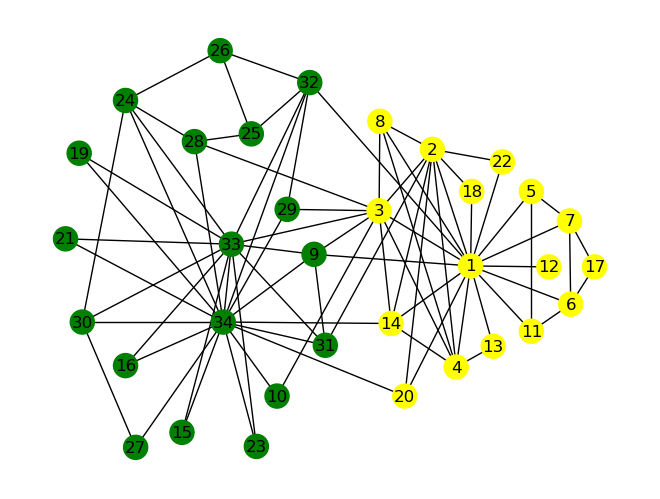

Computed Modularities
Q0: 0.37147 	 Q1: 0.37147


In [5]:
# Construct karate graph
karate = nx.Graph()
karate.add_edges_from([(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,11), (1,12), (1,13), (1,14), (1,18), (1,20), (1,22), (1,32), (2,3), (2,4), (2,8), (2,14), (2,18), (2,20), (2,22), (2,31), (3,4), (3,8), (3,9), (3,10), (3,14), (3,28), (3,29), (3,33), (4,8), (4,13), (4,14), (5,7), (5,11), (6,11), (6,17), (6,7), (7,17), (9,31), (9,33), (9,34), (10,34), (14,34), (15,33), (15,34), (16,33), (16,34), (19,33), (19,34), (20,34), (21,33), (21,34), (23,33), (23,34), (24,26), (24,28), (24,30), (24,33), (24,34), (25,26), (25,28), (25,32), (26,32), (27,30), (27,34), (28,34), (29,32), (29,34), (30,33), (30,34), (31,33), (31,34), (32,33), (32,34), (33,34)])
fixed_positions = {1:(10.74,4.07),2:(9.76,6.48),3:(8.39,5.21),4:(10.37,1.98),5:(12.30,5.61),6:(13.31,3.28),7:(13.28,5.00),8:(8.41,7.06),9:(6.72,4.31),10:(5.77,1.38),11:(12.30,2.72),12:(12.75,4.05),13:(11.32,2.41),14:(8.70,2.88),15:(3.33,0.63),16:(1.88,2.01),17:(13.92,4.05),18:(10.77,5.61),19:(0.69,6.40),20:(9.05,1.38),21:(0.34,4.63),22:(11.56,6.22),23:(5.24,0.34),24:(1.88,7.49),25:(5.11,6.80),26:(4.31,8.52),27:(2.14,0.32),28:(3.65,6.64),29:(6.03,5.24),30:(0.77,2.91),31:(7.01,2.43),32:(6.61,7.86),33:(4.60,4.52),34:(4.39,2.91)}
s   = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
sel = np.array([n-1 for n in karate]) 
s    = s[sel] # Reorder such that indices matches indices in networkx

node_col = ["yellow" if i == 1 else "green" for i in s]
nx.draw(karate,pos=fixed_positions, with_labels=True, node_color=node_col)
plt.show()

# Simple version
Q0 = s.T @ nx.modularity_matrix(karate) @ s  / (4 * karate.size())
Q1 = M_eq(karate, s)

assert np.allclose(Q0, Q1), "Modularity of Q0 (%.4f) and Q1 (%.4f) are not close" % (Q0, Q1)

print("Computed Modularities")
print("Q0: %.5f \t Q1: %.5f" % (Q0, Q1))

## Exercise 2: Limitations of Modularity
Having implemented Modularity function above, we can now try to stress test it a bit.

Below is some code that generate "cycle graphs" with cliques and computes the Modularity by your function `M_eq` from above.
The graphs generated vary in number of cliques and the size of the cliques.

We will observe, what happens to the Modularity score when we collapse cliques into larger clusters.

First run the following code and see an example of such a graph.

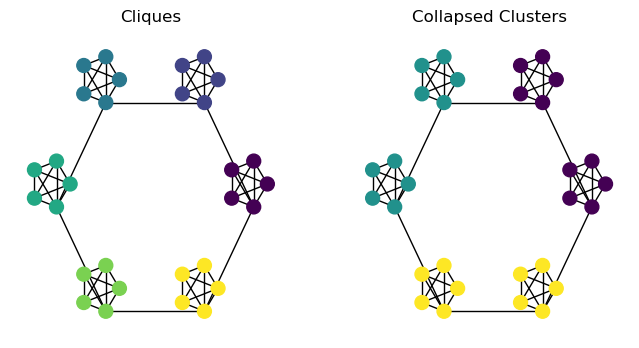

In [6]:
# Code for generating  cycles of cliques (See plots below.)
def clique_graph(cliques=8, sizes=4, radius=5):
    G = nx.Graph()
    pos = {}
    y = []
    
    # Compute circle offsets for plotting positions
    r = radius
    offsets = np.array([(np.cos(2.*r*np.pi/cliques), np.sin(2.*r*np.pi/cliques)) for r in range(cliques)]) * r
    
    # Add Cliques to the graph
    for clique, offset in enumerate(offsets):
        i_offset = clique * sizes
        mapping = {i: i_offset+i for i in range(sizes)}
        G_ = nx.complete_graph(sizes)
        G_ = nx.relabel_nodes(G_, mapping)
        
        p = nx.circular_layout(G_)
        for k in p.keys():
            p[k] += offset 
        
        G.add_nodes_from(G_.nodes)
        G.add_edges_from(G_.edges)
        pos = {**pos, **p}
        y += [clique] * sizes
        
    connections = [(i*sizes+(sizes-1), ((i+1)*sizes+(sizes-1))%G.order()) for i in range(cliques)]
    G.add_edges_from(connections)
    
    return G, pos, np.array(y)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
G, pos, y = clique_graph(6, 5) # 6 cliques of 5 nodes each
ax[0].set_title("Cliques")
ax[1].set_title("Collapsed Clusters")
nx.draw(G, pos=pos, ax=ax[0], node_color=y, node_size=100)
nx.draw(G, pos=pos, ax=ax[1], node_color=y//2, node_size=100)

Below we do the actual modularity computations on this kind of graphs.
In particular, we collapse cliques with their neighbors and those clusters with their neighbors and so on.

| Cliques    | Size       | Single     | Pairs      | Quads      | Octs       | 
-------------------------------------------------------------------------------
|         20 |          3 |    14.9280 |     3.7164 |     0.9075 |     0.2628 |
|         56 |          8 |   130.3783 |    32.5655 |     8.1126 |     1.9939 |
|          8 |         48 |     4.3358 |     1.0528 |     0.2133 |     0.0000 |


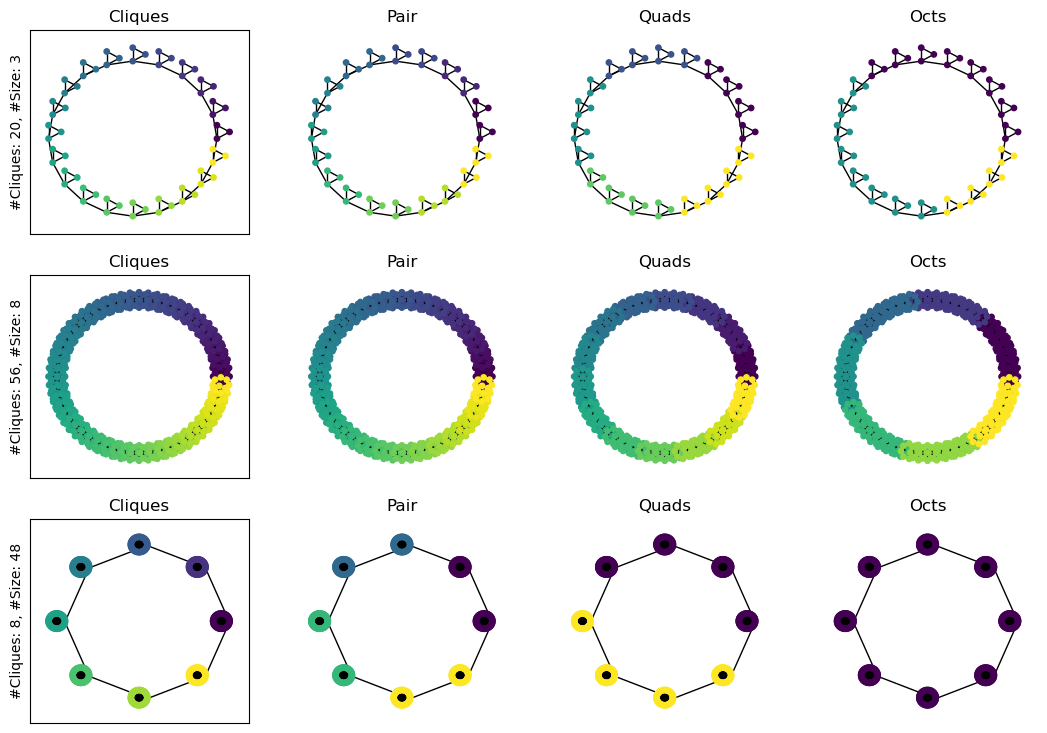

In [7]:
fig, ax = plt.subplots(3, 4, figsize=(13,9))
test_sizes = [(20, 3), (56, 8), (8, 48)]

modularities = []

for i, (c, s) in enumerate(test_sizes):
    G, pos, y = clique_graph(c, s, radius=10)
    
    # Plotting
    ax[i, 0].set_title("Cliques")
    ax[i, 0].set_ylabel("#Cliques: %d, #Size: %d" % (c, s))
    nx.draw(G, pos=pos, ax=ax[i, 0], node_size=15, node_color=y)
    ax[i, 0].set_axis_on()
    
    ax[i, 1].set_title("Pair")
    nx.draw(G, pos=pos, ax=ax[i, 1], node_size=15, node_color=y//2)
    ax[i, 2].set_title("Quads")
    nx.draw(G, pos=pos, ax=ax[i, 2], node_size=15, node_color=y//4)
    ax[i, 3].set_title("Octs")
    nx.draw(G, pos=pos, ax=ax[i, 3], node_size=15, node_color=y//8)

    # Computation of Modularity
    modularities.append([M_eq(G, y), M_eq(G, y//2), M_eq(G, y//4), M_eq(G, y//8)])

print(("| " + "%-10s | " * 6) % ("Cliques", "Size", "Single", "Pairs", "Quads", "Octs"))
print("-" * 79)
for (c, s), mod in zip(test_sizes, modularities):
    print("| " + "%10d | %10d | %10.4f | %10.4f | %10.4f | %10.4f |" % (c, s, *mod))

**Exercise 2.1:**  
1. In the graphs above, what would be the most natural "correct" clustering of the nodes?
2. Consider the output of the code above and describe what you observe. Is everything as you would expect?

## Exercise 3: Clique Percolation method
In this exercise, we will implement the Clique Percolation method for identifying (overlapping) communities.
Fill in the code below. The function `adjacent` returns `True` if two cliques of the same size are adjacent; feel free to use it.

1. Implement the algorithm below and test your algorithm below.
2. Try to do the smallest edit to the karate-graph to make the clique percolation method find only two communities for $K=4$.

In [8]:
def adjacent(l1, l2):
    l1_ = set(l1)
    l2_ = set(l2)
    
    k, k_ = len(l1_), len(l2_)
    if k != k_: return False
    
    l_  = l1_.union(l2_)
    return len(l_) == k+1

def clique_percolation(G, k=3):
    """
        args:
            G: A networkx graph
            k: size of cliques to use
        output:
            communities: list of communities; each community represented as a list of nodes 
            
        Example output:
            Two communitites. One community with node 1, 3, 6 and another with 1, 2, 4, 5.
            [ [1, 3, 6],  [1, 2, 4, 5] ]
    """
    communities = []
    # All cliques of size k in G
    cliques = [c for c in nx.enumerate_all_cliques(G) if len(c) == k]
    visited = [False] * len(cliques)
    
    while not all(visited):
        idx = [i for i, b in enumerate(visited) if not b]
        c = idx[np.random.choice(len(idx))]
        visited[c] = True
        
        community = [cliques[c]]
        old_size = -1
        size = len(community)
        while old_size != size:
            for i, clique in enumerate(cliques):
                if clique in community: continue
                for c in community:
                    if adjacent(c, clique):
                        community.append(clique)
                        visited[i] = True
                        break
            old_size = size
            size = len(community)
        communities.append(community)
                
    
    return communities

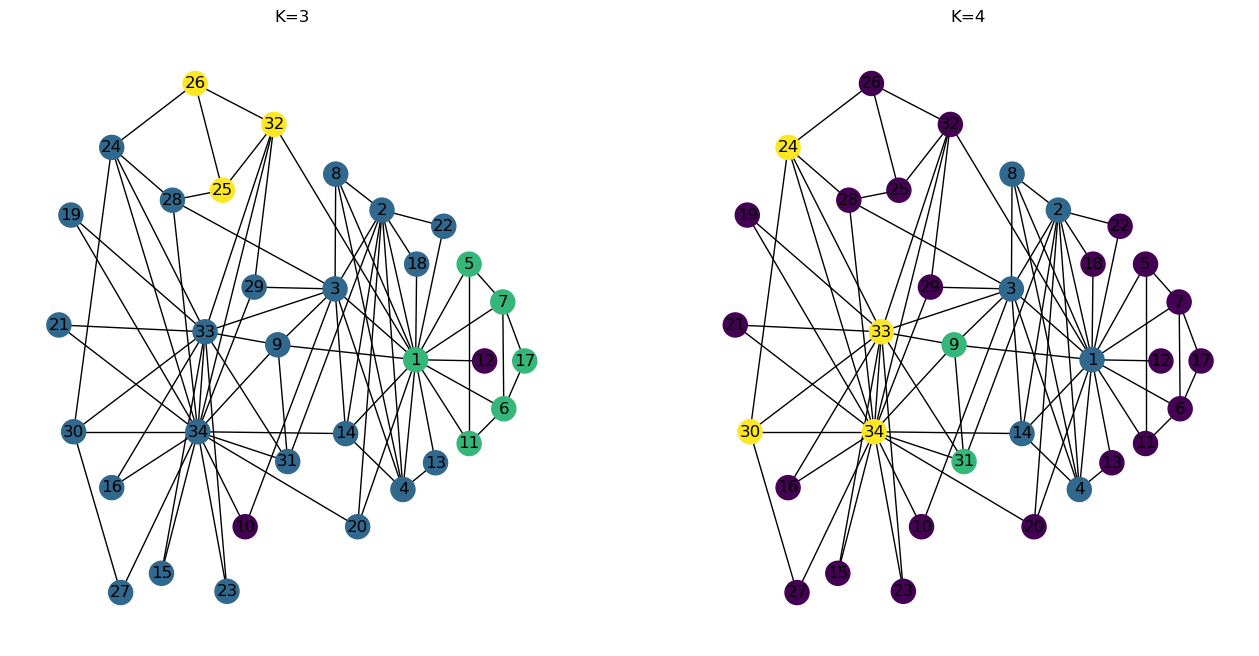

In [9]:
# Test of algorithm
def color_communities(communities, G):
    colors = {}
    for i, community in enumerate(communities):
        for cl in community:
            for idx in cl:
                    colors[idx] = i
    return [colors[k] if k in colors else -1 for k in G]

# Testing code by plotting found communities
community1 = clique_percolation(karate, k=3)
community2 = clique_percolation(karate, k=4)

y3 = color_communities(community1, karate)
y4 = color_communities(community2, karate)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title("K=3")
nx.draw(karate,pos=fixed_positions, ax=ax[0], with_labels=True, node_color=y3)
ax[1].set_title("K=4")
nx.draw(karate,pos=fixed_positions, ax=ax[1], with_labels=True, node_color=y4)

In [10]:
# Changing the Karate graph
karate2 = karate.__class__()
karate2.add_nodes_from(karate)
karate2.add_edges_from(karate.edges)

# TODO change `karate2` by adding or removing edges.

communities = clique_percolation(karate2, k=4)
y4          = color_communities(communities)
nx.draw(karate2, pos=fixed_positions, with_labels=True, node_color=y4)

TypeError: color_communities() missing 1 required positional argument: 'G'

## Exercise 4: BigClam 
In this exercise, we will be doing overlapping community detection with BigClam.
We will implement the log-likelihood function, the gradient function, and the iterative training.
Recall, that our model is going to be represented by a matrix $F \in \mathbb{R}^{n \times c}$, 
which has a row for each sample and a column for each community.

The log-likelihood is defined as follows:

$$
l\left(F_{u}\right)=\sum_{v \in \mathcal{N}(u)} \log \left(1-\exp \left(-F_{u} F_{v}^{T}\right)\right)-\sum_{v \notin \mathcal{N}(u)} F_{u} F_{v}^{T}
$$

and the associated gradient is

$$
\nabla l\left(F_{u}\right)=\sum_{v \in \mathcal{N}(u)} F_{v} \frac{\exp \left(-F_{u} F_{v}^{T}\right)}{1-\exp \left(-F_{u} F_{v}^{T}\right)}-\sum_{v \notin \mathcal{N}(u)} F_{v}
$$

Fill in the `TODO`s below and test your code.

In [15]:
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    A_soft = F @ F.T
    
    neighbor_loss = (A * np.log(1. - np.exp(-A_soft))).sum()
    non_neighbor_loss = ((1 - A) * A_soft).sum()
    return neighbor_loss - non_neighbor_loss

def gradient(F, A, i):
    _, C = F.shape
    
    neighbors = np.where(A[i]==1)
    non_neighbors = np.where(1 - A[i]==1)
    
    sum_neighbors = np.zeros((C,))
    
    for nb in neighbors[1]:
        dotproduct = F[nb].dot(F[i])
        sum_neighbors += F[nb] * sigm(dotproduct)
        
    sum_nneighbors = np.zeros((C,))
    
    for nnb in non_neighbors[1]:
        sum_nneighbors += F[nnb]
        

    grad = sum_neighbors - sum_nneighbors
    return grad

def train(A, C, epochs=100, lr=1e-3):
    n, _ = A.shape
    F = np.random.rand(n,C)

    # Gradient ascent on one note at a time
    loss = []
    for e in range(epochs): 
        for node_idx in range(n):
            
            grad = gradient(F, A, node_idx)
            
            # Gradient step
            F[node_idx] += lr * grad
            # Projection
            F[node_idx] = np.maximum(0.001, F[node_idx]) 
            
        ll = log_likelihood(F, A) # Used for plotting loss
        loss.append(ll)
        print('\rAt step %5i/%5i ll is %5.3f'%(e, epochs, ll), end="")
        
    print()
    return F, loss

In the code below you can try your implementation of the BigClam algorithm on different toy graphs.
You can choose from 7 different graphs.

In [16]:
# Cliques
G_clique, pos_clique, y = clique_graph(6, 10, radius=5)

# Tiny
G_tiny = nx.Graph()
G_tiny.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4), (4, 5), (5, 3)])

# Other graphs
K_20      = nx.complete_graph(20)
K_5_7    = nx.complete_bipartite_graph(5,7)
barbell  = nx.barbell_graph(10,10)
lollipop = nx.lollipop_graph(10,20)

# Options for graphs:
options = {
    'karate':    {'C': 2, 'G': karate,   'pos': fixed_positions},
    'cliques':   {'C': 5, 'G': G_clique, 'pos': pos_clique},
    'tiny':      {'C': 2, 'G': G_tiny,   'pos': None},
    'complete':  {'C': 3, 'G': K_20,     'pos': None},
    'bipartite': {'C': 2, 'G': K_5_7,    'pos': None},
    'barbell':   {'C': 3, 'G': barbell,  'pos': None},
    'lollipop':  {'C': 2, 'G': lollipop, 'pos': None},
}

choose = 'cliques'
G, C, pos = options[choose]['G'], options[choose]['C'], options[choose]['pos']

A = nx.adjacency_matrix(G).todense()
F, loss = train(A, C, 1000, 1e-3)

# Plot max communitise for each node
y = np.argmax(F, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(loss, label="Log-likelihood")
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Log-likelihood")

ax[1].set_title("Max Community value")
nx.draw(G, pos=pos, ax=ax[1], node_color=y, node_size=100)

# Visualize each individual community identified
fig, ax = plt.subplots(1, C, figsize=(C*4, 4))
for c in range(C):
    ax[c].set_title("Community %d" % (c+1))
    nx.draw(G, pos=pos, ax=ax[c], node_color=F[:,c], node_size=100)

IndexError: tuple index out of range